**Загрузка данных через API kaggle**

In [15]:
!pip install kaggle

In [0]:
import os
user = ''
key = ''
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [17]:
!kaggle competitions download -c airbus-ship-detection

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 37.8MB/s]
 28% 5.00M/18.0M [00:00<00:01, 8.08MB/s]
100% 18.0M/18.0M [00:00<00:00, 24.6MB/s]
100% 2.11G/2.12G [00:51<00:00, 36.7MB/s]
100% 2.12G/2.12G [00:51<00:00, 43.9MB/s]
100% 26.4G/26.4G [12:09<00:00, 45.4MB/s]
100% 26.4G/26.4G [12:10<00:00, 38.8MB/s]


In [0]:
!unzip train_v2.zip -d train

In [0]:
!unzip test_v2.zip -d test

In [0]:
!unzip train_ship_segmentations_v2.csv.zip

In [0]:
!unzip sample_submission_v2.csv

In [16]:
!ls

sample_data		  train
sample_submission_v2.csv  train_ship_segmentations_v2.csv
test			  train_ship_segmentations_v2.csv.zip
test_v2.zip		  train_v2.zip


In [0]:
# Libraries
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False

In [23]:
print('Total images for train: {0}'.format(len(os.listdir('train/'))))

print('Total images for test: {0}'.format(len(os.listdir('test/'))))

Total images for train: 192556
Total images for test: 15606


In [0]:
df = pd.read_csv('train_ship_segmentations_v2.csv')

In [25]:
df.iloc[9000:10000:100]

,ImageId,EncodedPixels
9000,09de3f56e.jpg,43302 1 44068 4 44834 6 45600 9 46367 10 47133...
9100,09f9afbe0.jpg,NaN
9200,0a1a2b14e.jpg,270999 2 271767 6 272535 10 273302 13 274070 1...
9300,0a2e15e29.jpg,550881 2 551649 4 552416 7 553184 10 553951 13...
9400,0a4aa1eb8.jpg,NaN
9500,0a6a3e100.jpg,NaN
9600,0a8ac4183.jpg,NaN
9700,0aa505b96.jpg,351568 2 352336 5 353104 7 353871 8 354639 7 3...
9800,0ab8c8d6f.jpg,84643 1 85409 4 86176 6 86942 8 87709 10 88478...
9900,0acfb1627.jpg,544122 2 544888 5 545655 6 546424 6 547192 6 5...


Каждой картинке может соостветствовать 1 и более маска, но для каждой из масок выделен отдельный row в датафрейме, таким образом если на одной картинке сегментированы и закодированы в rle последовательность скажем 5 кораблей, то в датафрейме будет 5 одинаковых наименований в column **ImageId** и 5 различных row в column  **EncodedPixels** каждый из которых будет соответствовать 1 кораблю.

In [26]:
# Picture with 14 ships
df[df['ImageId'] == '90c4c298c.jpg']

,ImageId,EncodedPixels
131237,90c4c298c.jpg,262363 1 263130 4 263898 5 264665 7 265432 10 ...
131238,90c4c298c.jpg,176818 2 177584 4 178350 7 179116 9 179883 11 ...
131239,90c4c298c.jpg,183625 4 184393 17 185161 29 185929 41 186697 ...
131240,90c4c298c.jpg,113339 2 114105 4 114871 7 115636 10 116402 12...
131241,90c4c298c.jpg,145183 5 145951 14 146719 23 147487 32 148254 ...
131242,90c4c298c.jpg,155915 7 156683 19 157451 31 158219 41 158987 ...
131243,90c4c298c.jpg,119797 2 120562 5 121328 8 122096 8 122865 7 1...
131244,90c4c298c.jpg,115665 2 116430 5 117195 9 117960 12 118725 15...
131245,90c4c298c.jpg,284089 1 284855 4 285621 7 286388 8 287154 11 ...
131246,90c4c298c.jpg,146580 1 147346 4 148113 6 148879 8 149646 10 ...


In [27]:
# 14 rle encoded rows
df.loc[df['ImageId'] == '90c4c298c.jpg', 'EncodedPixels']

131237    262363 1 263130 4 263898 5 264665 7 265432 10 ...
131238    176818 2 177584 4 178350 7 179116 9 179883 11 ...
131239    183625 4 184393 17 185161 29 185929 41 186697 ...
131240    113339 2 114105 4 114871 7 115636 10 116402 12...
131241    145183 5 145951 14 146719 23 147487 32 148254 ...
131242    155915 7 156683 19 157451 31 158219 41 158987 ...
131243    119797 2 120562 5 121328 8 122096 8 122865 7 1...
131244    115665 2 116430 5 117195 9 117960 12 118725 15...
131245    284089 1 284855 4 285621 7 286388 8 287154 11 ...
131246    146580 1 147346 4 148113 6 148879 8 149646 10 ...
131247    525517 1 526283 4 527049 6 527815 9 528581 11 ...
131248    227803 21 228571 21 229339 21 230107 21 230875...
131249    256997 1 257764 3 258531 5 259297 8 260064 9 2...
131250    217072 20 217821 39 218589 39 219357 39 220125...
Name: EncodedPixels, dtype: object

In [0]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768,768)):
  '''
  mask_rle: run-length as string formated(start length)
  shape: (height,width) of array to return
  Returns numpy array, 1 - mask, 0 - background
  '''
  img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
  
  s = mask_rle.split()
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  for lo, hi in zip(starts,ends):
      img[lo:hi] = 1
      
  img = img.reshape(shape).T # Needed to align to RLE direction
  return img

In [0]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

**Example**

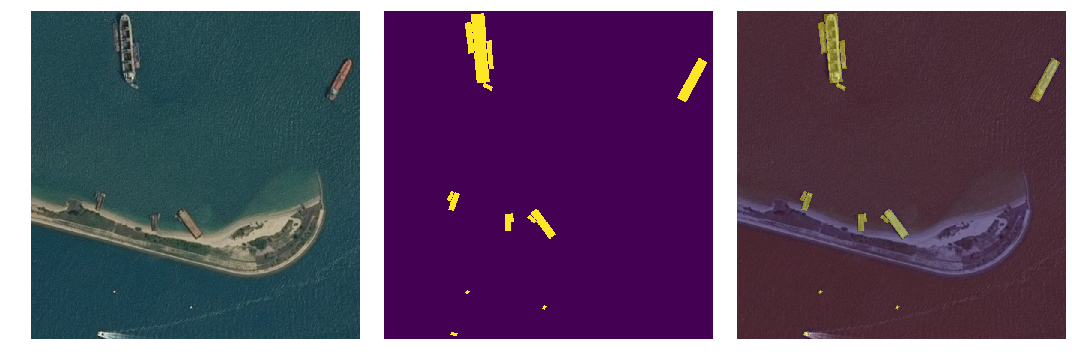

In [30]:
# Picture with 14 ships
ImageId = '90c4c298c.jpg'

img = cv2.imread('train/{}'.format(ImageId))
img_masks = df.loc[df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img[...,[2,1,0]]) #rgb
axarr[1].imshow(all_masks, cmap='viridis')
axarr[2].imshow(img, cmap='viridis')
axarr[2].imshow(all_masks, alpha=0.4, cmap='viridis')
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

# Подвыборка пустых изображений
Сделаем подвыборку с умереным количеством пустых изображений, которая послужит  шумом, тем самым регулируя сложность будущей модели .

In [0]:
masks = df.drop(df[df['EncodedPixels'].isnull()].sample(70000,random_state=42).index)


In [32]:
masks.shape

(161723, 2)

In [33]:
len(masks['EncodedPixels'].value_counts())

81722


# Split into training and validation groups
Так как уже известно что одной картинке может соответсвовать 1 и больше кораблей,то в разделенной выборке хотелось бы иметь стратифицированое разделения по количеству кораблей

In [34]:
from sklearn.model_selection import train_test_split

# Новый df сгрупированый по кол-ву кораблей которые приходяться на 1 картинку
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='Counts')

# Стратифицированое разделения происходит на только что созданом column Counts
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['Counts'],
                 random_state=42)


# Соединение стратифицированой выборки с оригинальной, 
# где каждой картинке может соответсвовать более 1го rows.

train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

153636 training masks
8087 validation masks


In [35]:
train_df.head()

,ImageId,EncodedPixels,Counts
0,0001124c7.jpg,NaN,1
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
3,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
4,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5


In [36]:
valid_df.head()

,ImageId,EncodedPixels,Counts
0,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
1,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...,2
2,001e3f475.jpg,NaN,1
3,001eda01f.jpg,368419 8 369187 8 369955 8 370723 8 371491 8 3...,1
4,002abd5df.jpg,NaN,1


In [0]:
# Там где NaN кол-во будет 0
train_df['Counts'] = train_df.apply(lambda c_row: c_row['Counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['Counts'] = valid_df.apply(lambda c_row: c_row['Counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

In [38]:
train_df.head()

,ImageId,EncodedPixels,Counts
0,0001124c7.jpg,NaN,0
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
3,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
4,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5


In [39]:
valid_df.head()

,ImageId,EncodedPixels,Counts
0,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
1,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...,2
2,001e3f475.jpg,NaN,0
3,001eda01f.jpg,368419 8 369187 8 369955 8 370723 8 371491 8 3...,1
4,002abd5df.jpg,NaN,0


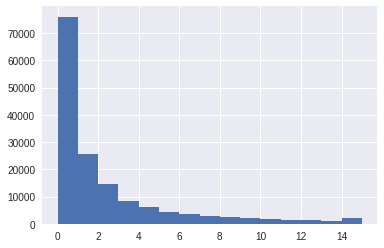

In [40]:
# Проверим соотношения кораблей в выборках
train_df['Counts'].hist(bins=15);

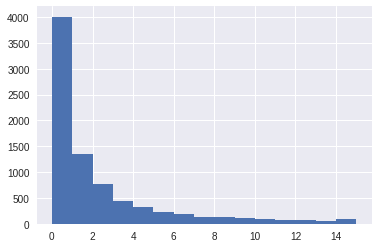

In [41]:
valid_df['Counts'].hist(bins=15);

In [42]:
print(train_df['ImageId'].nunique(), 'unique images in train set')

116428 unique images in train set


In [43]:
print(valid_df['ImageId'].nunique(),'unique images in test set')

6128 unique images in test set


#  Data generator  for keras

In [0]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [0]:
# Hyper parameters
IMG_SCALING = (1, 1)

def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join('train', c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [47]:
# Проверка размерности
train_gen = keras_generator(train_df,5)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (5, 768, 768, 3) 0.0 1.0
y (5, 768, 768, 1) 0 1


# Segnet

**SegNet**

![](http://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import GlobalAveragePooling2D, UpSampling2D, Conv2D, MaxPooling2D

In [49]:
inp = Input(shape=(768,768,3))

# first block
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


# second block
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


# third block
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


# fourth block
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# fifth block
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_4_2)


# first decoding block
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


# second decoding block
up_2 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


# third decoding block
up_3 = UpSampling2D(2, interpolation='bilinear')(pool_3)
conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# fourth decoding block
up_4 = UpSampling2D(2, interpolation='bilinear')(pool_2)
conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)


# fifth decoding block
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(up_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


segnet_model = Model(inputs=inp, outputs=result)
segnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 768, 768, 3)       0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 768, 768, 32)      896       
_________________________________________________________________
activation_109 (Activation)  (None, 768, 768, 32)      0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 768, 768, 32)      9248      
_________________________________________________________________
activation_110 (Activation)  (None, 768, 768, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 384, 384, 32)      0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 384, 384, 64)      18496     
__________

In [0]:
# callbacks

best_w = keras.callbacks.ModelCheckpoint('best_segnet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('last_segnet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

**Custom loss**

In [0]:

import keras.backend as K
from keras.losses import binary_crossentropy


## IoU of boats
def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

## IoU of non-boats
def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return -1e-2 * zero_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
  

# optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  
  
  
  
segnet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, zero_IoU, 'binary_accuracy'])

**Start train**

In [57]:
loss_history = segnet_model.fit_generator(keras_generator(train_df),
                                        steps_per_epoch=100, 
                                        epochs=5, 
                                        validation_data=keras_generator(valid_df),
                                        validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
100/100 [==============================] - 125s 1s/step - loss: -0.3238 - IoU: 0.3143 - zero_IoU: 0.9525 - binary_accuracy: 0.9785 - val_loss: -0.6550 - val_IoU: 0.6450 - val_zero_IoU: 0.9986 - val_binary_accuracy: 0.9986
Epoch 2/5
100/100 [==============================] - 91s 913ms/step - loss: -0.6625 - IoU: 0.6525 - zero_IoU: 0.9985 - binary_accuracy: 0.9985 - val_loss: -0.6350 - val_IoU: 0.6250 - val_zero_IoU: 0.9978 - val_binary_accuracy: 0.9978
Epoch 3/5
100/100 [==============================] - 91s 912ms/step - loss: -0.6625 - IoU: 0.6525 - zero_IoU: 0.9979 - binary_accuracy: 0.9979 - val_loss: -0.6300 - val_IoU: 0.6200 - val_zero_IoU: 0.9979 - val_binary_accuracy: 0.9979
Epoch 4/5
100/100 [==============================] - 92s 915ms/step - loss: -0.6800 - IoU: 0.6700 - zero_IoU: 0.9982 - binary_accuracy: 0.9982 - val_loss: -0.6700 - val_IoU: 0.6600 - val_zero_IoU: 0.9980 - val_binary_accuracy: 0.9980
Epoch 5/5
100/100 

# Unet

**Unet**
![alt](https://pics.spark-in.me/upload/98bb30833b833a1ef9199feca3b9ed5c.png)

In [98]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(768, 768, 3))

# first block
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


# second block
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


# third block
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


# fourth block
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# fifth block
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)


# first decoding block
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conc_1 = Concatenate()([conv_5_2, up_1])

conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

# second decoding block
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_4_2, up_2])

conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


# third decodinc block
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_3_2, up_3])

conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# fourth decoding block
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_2_2, up_4])

conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)


# fifth decoding block
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([conv_1_2, up_5])
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


unet_model = Model(inputs=inp, outputs=result)

unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_235 (Conv2D)             (None, 768, 768, 32) 896         input_16[0][0]                   
__________________________________________________________________________________________________
activation_235 (Activation)     (None, 768, 768, 32) 0           conv2d_235[0][0]                 
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 768, 768, 32) 9248        activation_235[0][0]             
__________________________________________________________________________________________________
activation

In [0]:
# callbacks

best_w = keras.callbacks.ModelCheckpoint('best_unet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('last_unet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

**Custom loss**

In [0]:
import keras.backend as K
from keras.losses import binary_crossentropy


## IoU of boats
def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

## IoU of non-boats
def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return -1e-2 * zero_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
  

# optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  
  
  
  
unet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, zero_IoU, 'binary_accuracy'])

**Start train**

In [101]:
loss_history = unet_model.fit_generator(keras_generator(train_df),
                                        steps_per_epoch=100, 
                                        epochs=5, 
                                        validation_data=keras_generator(valid_df),
                                        validation_steps=50)

Epoch 1/5
100/100 [==============================] - 247s 2s/step - loss: -0.5726 - IoU: 0.5628 - zero_IoU: 0.9757 - binary_accuracy: 0.9982 - val_loss: -0.6750 - val_IoU: 0.6650 - val_zero_IoU: 0.9988 - val_binary_accuracy: 0.9988
Epoch 2/5
100/100 [==============================] - 223s 2s/step - loss: -0.6750 - IoU: 0.6650 - zero_IoU: 0.9985 - binary_accuracy: 0.9985 - val_loss: -0.7400 - val_IoU: 0.7300 - val_zero_IoU: 0.9988 - val_binary_accuracy: 0.9988
Epoch 3/5
100/100 [==============================] - 222s 2s/step - loss: -0.7100 - IoU: 0.7000 - zero_IoU: 0.9987 - binary_accuracy: 0.9987 - val_loss: -0.6550 - val_IoU: 0.6450 - val_zero_IoU: 0.9980 - val_binary_accuracy: 0.9980
Epoch 4/5
100/100 [==============================] - 222s 2s/step - loss: -0.6650 - IoU: 0.6550 - zero_IoU: 0.9980 - binary_accuracy: 0.9980 - val_loss: -0.6800 - val_IoU: 0.6700 - val_zero_IoU: 0.9984 - val_binary_accuracy: 0.9984
Epoch 5/5
100/100 [==============================] - 222s 2s/step - loss